In [7]:
import numpy as np
import matplotlib.pyplot as plt

def feature_transform(lines):
    X = []
    truth = []

    for line in lines:
        values = list(map(float, line.split()))
        label = values[0]
        values = values[1:]  # Remove label (1 or 5)
        assert(len(values) == 256)
       
        horiz_sym = 0
        vert_sym = 0
        for i in range(16):
            for j in range(8):
                horiz_sym += abs(values[i*16 + j] - values[i*16 + 15-j])
        for i in range(8):
            for j in range(16):
                vert_sym += abs(values[i*16 + j] - values[(15-i)*16 + j])
        horiz_sym = horiz_sym / 128.0
        vert_sym = vert_sym / 128.0
        
        X.append([1, vert_sym, horiz_sym])
        truth.append(1 if label == 1.0 else -1)

    return np.array(X), np.array(truth)

def polynomial_transform(X):
    n_samples = len(X)
    features = []
    
    for i in range(n_samples):
        x_1, x_2 = X[i][1], X[i][2]  # Skip bias term
        row_features = []
        row_features.append(1)  # Bias term
        row_features.append(x_1)
        row_features.append(x_2)
        row_features.append(x_1 ** 2)
        row_features.append(x_1 * x_2)
        row_features.append(x_2 ** 2)
        row_features.append(x_1 ** 3)
        row_features.append(x_1 ** 2 * x_2)
        row_features.append(x_1 * x_2 ** 2)
        row_features.append(x_2 ** 3)
        features.append(row_features)
    
    return np.array(features)

def calculate_e_in(X, truth, weights):
    e_in = 0
    for x, truth_value in zip(X, truth):
        prediction = np.sign(np.dot(weights, x))
        prediction = int(prediction)
        if prediction != truth_value:
            e_in += 1
    return e_in / len(X)

def PLA_Pocket(X, truth, starting_weights=None, iterations=10000):

    if starting_weights is None:
        weights = np.zeros(X.shape[1], dtype=float)
    else:
        weights = starting_weights.copy()

    iteration = 0
    best_weights = weights # Pocket weights
    best_e_in = calculate_e_in(X, truth, best_weights)
    while iteration < iterations:
        
        exit = True
        for x, truth_value in zip(X, truth):
        
            prediction = np.sign(np.dot(weights, x))
            prediction = int(prediction)

            # Updates weights
            if prediction != truth_value:
                exit = False
                weights += x * truth_value
        
        if exit:
            break
        
        e_in = calculate_e_in(X, truth, weights)
        if e_in < best_e_in:
            best_weights = weights.copy()
            best_e_in = e_in

        iteration += 1

    return best_weights

def linear_regression(X, truth):

    X_psuedo_inv = np.dot(np.linalg.inv(np.dot(X.T, X)), X.T)
    weights = np.dot(X_psuedo_inv, truth)

    return weights

def logistic_regression(X, truth, eta=.01, iterations=10000):

    weights = np.zeros(X.shape[1], dtype=float)
    N = len(X)
    for _ in range(iterations):
        
        summation = np.zeros_like(weights)
        for x_n, y_n in zip(X,truth):
            summation += y_n * x_n / (1 + np.exp(y_n * np.dot(weights, x_n)))
        g_t = -1 / N * summation
        v_t = -g_t
        weights += eta * v_t

    return weights

def logistic_regression_sgd(X, truth, eta=.001, iterations=10000):

    weights = np.zeros(X.shape[1], dtype=float)
    for _ in range(iterations):
        
        for x_n, y_n in zip(X,truth):
            g_t = -1 *y_n * x_n / (1 + np.exp(y_n * np.dot(weights, x_n)))
            v_t = -g_t
            weights += eta * v_t
        

    return weights

def plot_decision_boundary(X, truth, weights, show_data=True):
    
    plt.figure(figsize=(10, 6))
    
    vert_sym = X[:, 1]
    horiz_sym = X[:, 2]
    
    if show_data:
        plt.scatter(vert_sym[truth == 1], horiz_sym[truth == 1], 
                   color='blue', marker='o', label='1', alpha=0.5, s=50)
        plt.scatter(vert_sym[truth == -1], horiz_sym[truth == -1], 
                   color='red', marker='x', label='5', alpha=0.5, s=50)
    
    x_vals = np.linspace(min(vert_sym), max(vert_sym), 100)
    y_vals = -(weights[1] * x_vals + weights[0]) / weights[2]
    plt.plot(x_vals, y_vals, label='Decision Boundary', color='black', linewidth=2)
    
    plt.xlabel('Vertical Symmetry')
    plt.ylabel('Horizontal Symmetry')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_third_order_decision_boundary(X, truth, weights, show_data=True):
    
    plt.figure(figsize=(10, 6))
    
    vert_sym = X[:, 1]
    horiz_sym = X[:, 2]
    
    if show_data:
        plt.scatter(vert_sym[truth == 1], horiz_sym[truth == 1], 
                   color='blue', marker='o', label='1', alpha=0.5, s=50)
        plt.scatter(vert_sym[truth == -1], horiz_sym[truth == -1], 
                   color='red', marker='x', label='5', alpha=0.5, s=50)
    
    x_vals = np.linspace(min(vert_sym), max(vert_sym), 100)
    y_vals = np.linspace(min(horiz_sym), max(horiz_sym), 100)
    X_grid, Y_grid = np.meshgrid(x_vals, y_vals)
    
    Z = (weights[0] + 
         weights[1] * X_grid + 
         weights[2] * Y_grid +
         weights[3] * X_grid ** 2 + 
         weights[4] * X_grid * Y_grid + 
         weights[5] * Y_grid ** 2 + 
         weights[6] * X_grid ** 3 +
         weights[7] * X_grid ** 2 * Y_grid +
         weights[8] * X_grid * Y_grid ** 2 +
         weights[9] * Y_grid ** 3)
    
    plt.contour(X_grid, Y_grid, Z, levels=[0], colors='green', linewidths=2, label='Decision Boundary')
    
    plt.xlabel('Vertical Symmetry')
    plt.ylabel('Horizontal Symmetry')
    plt.legend()
    plt.show()

train_input_file = 'clean_ZipDigits.train.txt'
with open(train_input_file, 'r') as f:
    train_lines = f.readlines()

test_input_file = 'clean_ZipDigits.test.txt'
with open(test_input_file, 'r') as f:
    test_lines = f.readlines()

X_train, truth_train = feature_transform(train_lines)
X_test, truth_test = feature_transform(test_lines)

X_train_poly = polynomial_transform(X_train)
X_test_poly = polynomial_transform(X_test)

E_in: 0.0025624599615631004
E_test: 0.018867924528301886


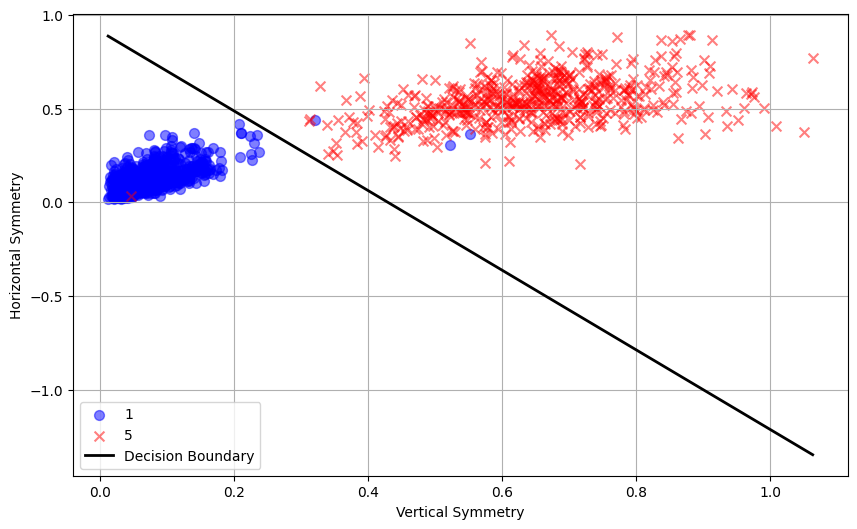

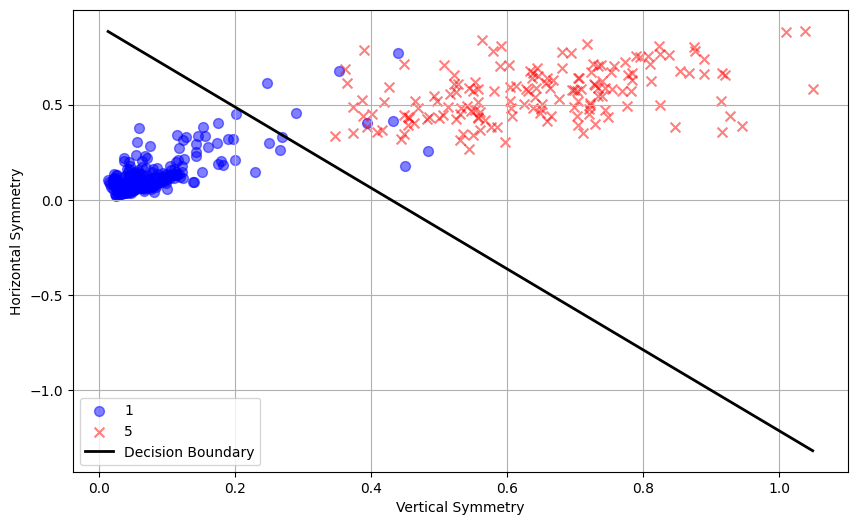

3rd Order Transform
E_in: 0.0025624599615631004
E_test: 0.02122641509433962


C:\Users\Joe\AppData\Local\Temp\ipykernel_49708\2201825585.py:181: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, Z, levels=[0], colors='green', linewidths=2, label='Decision Boundary')


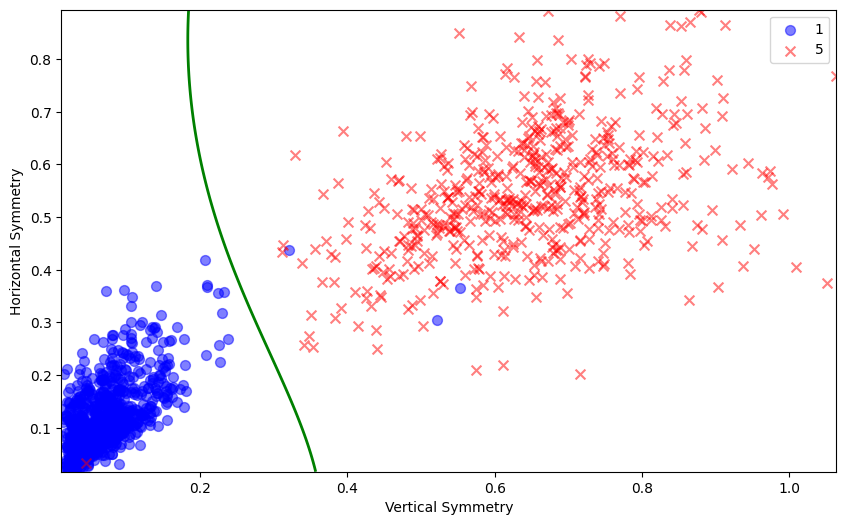

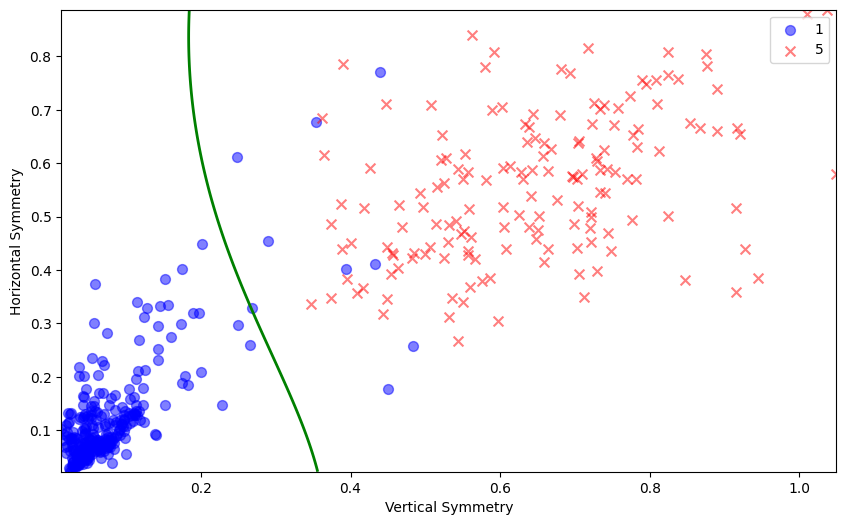

In [8]:
""" Linear Regression followed by Perceptron Learning Algorithm """
# Training
linear_regression_weights = linear_regression(X_train, truth_train)
PLA_weights = PLA_Pocket(X_train, truth_train, linear_regression_weights)

# 3rd Order Transform Training
linear_regression_weights = linear_regression(X_train_poly, truth_train)
PLA_weights_poly = PLA_Pocket(X_train_poly, truth_train, linear_regression_weights)

# Calculating Error
e_in = calculate_e_in(X_train, truth_train, PLA_weights)
e_test = calculate_e_in(X_test, truth_test, PLA_weights)
e_in_poly = calculate_e_in(X_train_poly, truth_train, PLA_weights_poly)
e_test_poly = calculate_e_in(X_test_poly, truth_test, PLA_weights_poly)

# Printing Results
print('E_in:', e_in)
print('E_test:', e_test)
plot_decision_boundary(X_train, truth_train, PLA_weights)
plot_decision_boundary(X_test, truth_test, PLA_weights)

print('3rd Order Transform')
print('E_in:', e_in_poly)
print('E_test:', e_test_poly)
plot_third_order_decision_boundary(X_train_poly, truth_train, PLA_weights_poly)
plot_third_order_decision_boundary(X_test_poly, truth_test, PLA_weights_poly)

E_in: 0.005765534913516977
E_test: 0.01650943396226415


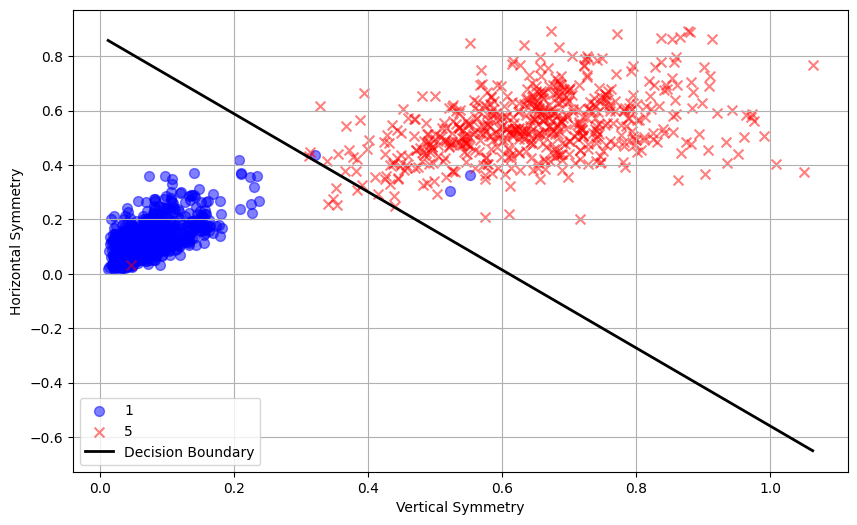

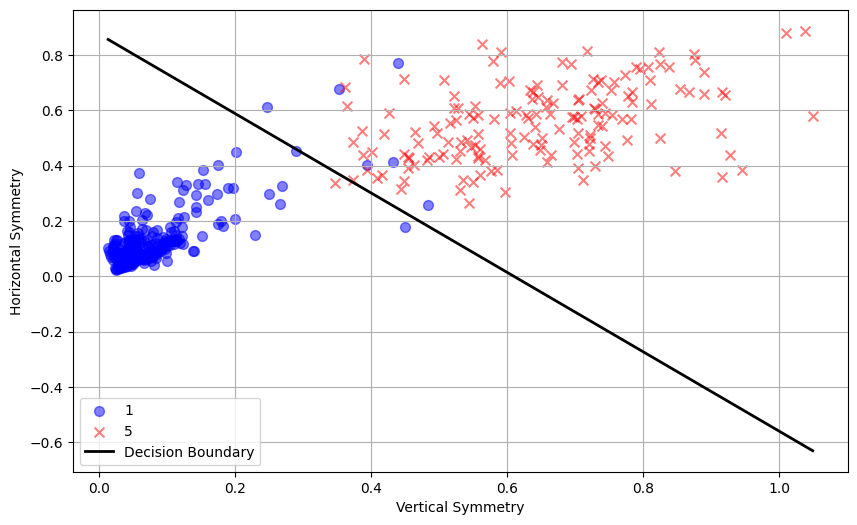

3rd Order Transform
E_in: 0.011531069827033953
E_test: 0.02122641509433962


C:\Users\Joe\AppData\Local\Temp\ipykernel_49708\2201825585.py:181: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, Z, levels=[0], colors='green', linewidths=2, label='Decision Boundary')


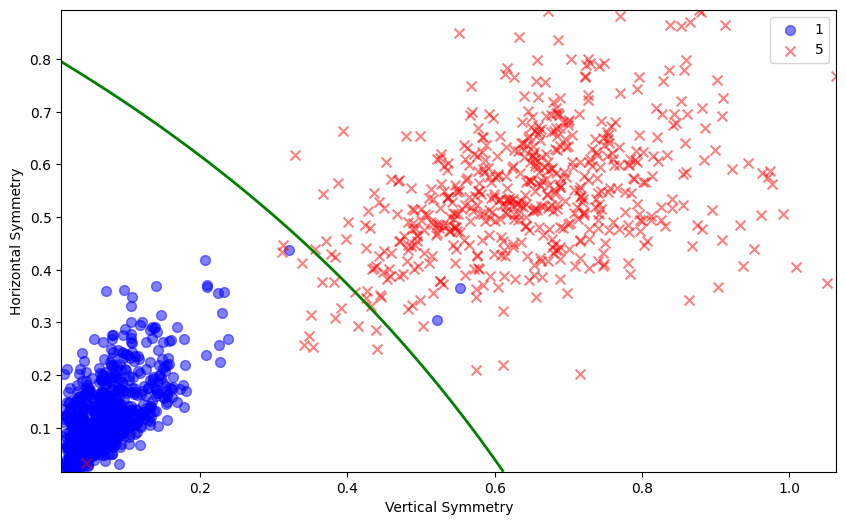

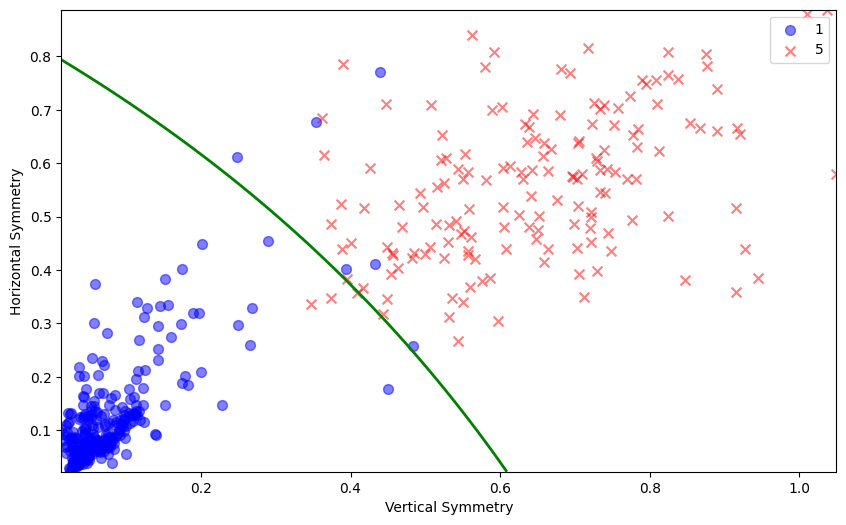

In [9]:
""" Logistic Regression using Gradient Descent """
# Training
logistic_regression_weights = logistic_regression(X_train, truth_train)

# 3rd Order Transform Training
logistic_regression_weights_poly = logistic_regression(X_train_poly, truth_train)

# Calculating Error
e_in = calculate_e_in(X_train, truth_train, logistic_regression_weights)
e_test = calculate_e_in(X_test, truth_test, logistic_regression_weights)
e_in_poly = calculate_e_in(X_train_poly, truth_train, logistic_regression_weights_poly)
e_test_poly = calculate_e_in(X_test_poly, truth_test, logistic_regression_weights_poly)

# Printing Results
print('E_in:', e_in)
print('E_test:', e_test)
plot_decision_boundary(X_train, truth_train, logistic_regression_weights)
plot_decision_boundary(X_test, truth_test, logistic_regression_weights)

print('3rd Order Transform')
print('E_in:', e_in_poly)
print('E_test:', e_test_poly)
plot_third_order_decision_boundary(X_train_poly, truth_train, logistic_regression_weights_poly)
plot_third_order_decision_boundary(X_test_poly, truth_test, logistic_regression_weights_poly)

E_in: 0.0032030749519538757
E_test: 0.018867924528301886


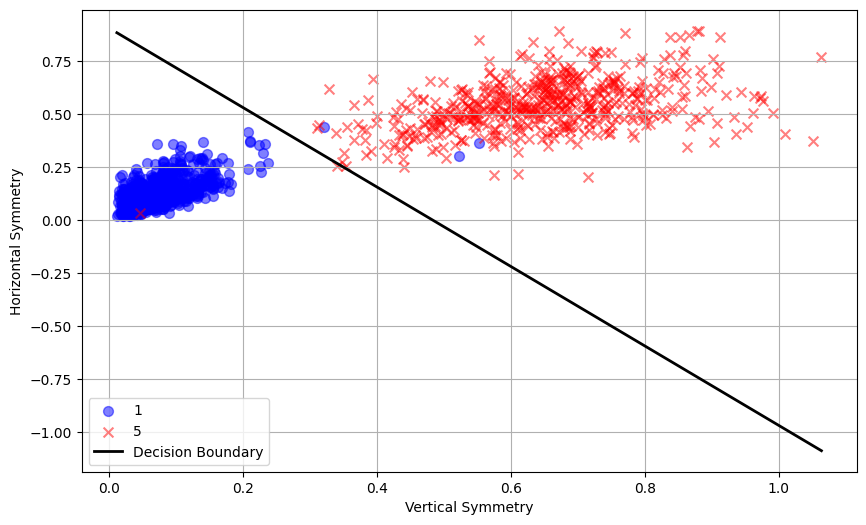

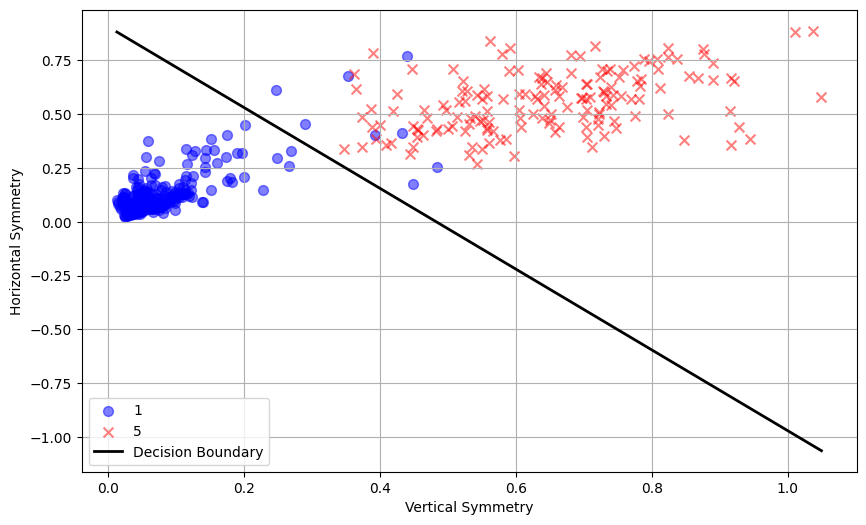

3rd Order Transform
E_in: 0.004484304932735426
E_test: 0.018867924528301886


C:\Users\Joe\AppData\Local\Temp\ipykernel_49708\2201825585.py:181: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, Z, levels=[0], colors='green', linewidths=2, label='Decision Boundary')


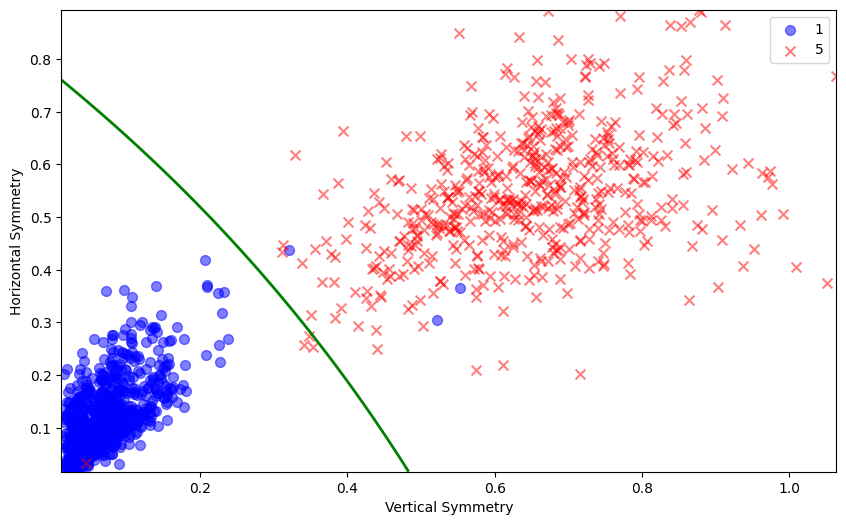

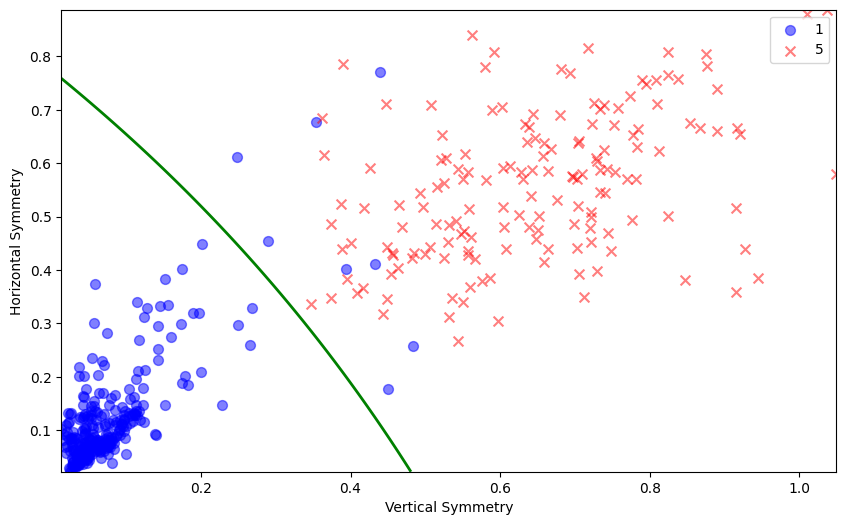

In [10]:
""" Logistic Regression using Stochastic Gradient Descent """
# Training
logistic_regression_weights_sgd = logistic_regression_sgd(X_train, truth_train)
logistic_regression_weights_sgd_poly = logistic_regression_sgd(X_train_poly, truth_train)
# 3rd Order Transform Training

# Calculating Error
e_in = calculate_e_in(X_train, truth_train, logistic_regression_weights_sgd)
e_test = calculate_e_in(X_test, truth_test, logistic_regression_weights_sgd)
e_in_poly = calculate_e_in(X_train_poly, truth_train, logistic_regression_weights_sgd_poly)
e_test_poly = calculate_e_in(X_test_poly, truth_test, logistic_regression_weights_sgd_poly)

# Printing Results
print('E_in:', e_in)
print('E_test:', e_test)
plot_decision_boundary(X_train, truth_train, logistic_regression_weights_sgd)
plot_decision_boundary(X_test, truth_test, logistic_regression_weights_sgd)

print('3rd Order Transform')
print('E_in:', e_in_poly)
print('E_test:', e_test_poly)
plot_third_order_decision_boundary(X_train_poly, truth_train, logistic_regression_weights_sgd_poly)
plot_third_order_decision_boundary(X_test_poly, truth_test, logistic_regression_weights_sgd_poly)